In [143]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from gluonts.dataset.repository import dataset_recipes


from gluonts.dataset.split import split
import numpy as np
import torch
from einops import rearrange
from uni2ts.eval_util.data import get_gluonts_test_dataset
from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

from gluonts.dataset.pandas import PandasDataset
from obspy.clients.fdsn import Client

import obspy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Settings
SIZE: model size, select the model size of Moirai to perform inference with

CTX: context length, how many time steps the model will take as input for inference

PSZ: patch size, how many time steps to perform patching with

BSZ: batch size, number of samples in each batch for inference

In [144]:
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
CTX = 368  # context length: any positive integer
PRED = 60  # prediction length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer

### Prepare dataset

We will load an earthquake catalog using obspy.

In [145]:
# Create a client to connect to the SCEDC data center
client = Client("SCEDC")

# download a SCEDC earthquake catalog using obspy
starttime = obspy.UTCDateTime("2016-01-01")
endtime = obspy.UTCDateTime("2020-01-01")
minlatitude = 32.0
minlongitude = -125.0
maxlatitude = 42.0
maxlongitude = -114.0
minmagnitude = 6
quake_catalog = client.get_events(starttime=starttime,\
             endtime=endtime, minlatitude=minlatitude, \
                minlongitude=minlongitude, maxlatitude=maxlatitude, \
                    maxlongitude=maxlongitude, minmagnitude=minmagnitude)
print(quake_catalog)

In [147]:
# get a seismogram from CI.RPV..BHZ for the large earthquake in the first element of quake_catalog
event = quake_catalog[0]
origin = event.origins[0]
# convert the origin time to a UTCDateTime object
event_time = obspy.UTCDateTime(origin.time)
z=client.get_waveforms("CI", "RPV", "", "BH*", event_time, event_time + 60*10)
# downsample to df Hz

df = 5
z.resample(df)
z.plot()
data = np.zeros(shape=(3, len(z[0].data)))
data[0] = z[0].data
data[1] = z[1].data
data[2] = z[2].data
plt.plot(data.T)


            target
2010-01-01       1
2010-01-04       4
2010-01-07       1
2010-01-08       1
2010-01-10       6
...            ...
2019-12-21       2
2019-12-25       1
2019-12-26       2
2019-12-27       1
2019-12-28       2

[1517 rows x 1 columns]


In [ ]:
# now we are going to reshape the data into a format that can be used by the ChronosPipeline
# data = np.expand_dims(data, axis=0)
prediction_length = int(10*df)
last_date = int(160*df)
start_date = int(20*df)
#create a time vector with sampling rate df
time = np



plt.plot(data[:,start_date:last_date+prediction_length].T)
plt.plot(data[:,start_date:last_date].T);

In [149]:
# create a sample for the daily data, using 1 year data as context window and predicting the next 2 months.
inp = {
    "target": event_counts_df["target"].to_numpy()[:CTX],  
    "start": event_counts_df.index[0].to_period(freq="D"),
}
label = {
    "target": event_counts_df["target"].to_numpy()[CTX:CTX+PRED], 
    "start": event_counts_df.index[CTX].to_period(freq="D"),
}

In [150]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=PRED,
    context_length=CTX,
    patch_size=32,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

# Time series values. Shape: (batch, time, variate)
past_target = rearrange(
    torch.as_tensor(inp["target"], dtype=torch.float32), "t -> 1 t 1" # 1 batch, t time, 1 variate
)
# 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
# 1s if the value is padding, 0s otherwise. Shape: (batch, time)
past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)


In [151]:
print("Shape of past_target:", past_target.shape)
print("Shape of past_observed_target:", past_observed_target.shape)
print("Shape of past_is_pad:", past_is_pad.shape)

Shape of past_target: torch.Size([1, 368, 1])
Shape of past_observed_target: torch.Size([1, 368, 1])
Shape of past_is_pad: torch.Size([1, 368])


In [152]:

forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad)

In [153]:
forecast

tensor([[[ 1.0947e+00,  5.0639e+02,  1.1756e+00,  ...,  4.6237e+00,
           1.0532e+00,  1.2535e+00],
         [ 1.1978e+00,  8.1020e-02,  3.5379e+00,  ...,  6.9215e-01,
           2.4000e+00,  5.5338e-02],
         [ 1.3182e+00, -2.7200e+00,  3.2358e-01,  ...,  1.0842e+00,
           4.3217e-01, -1.8183e-02],
         ...,
         [ 7.4390e-01,  1.0953e+00,  2.6916e+00,  ...,  1.0603e+00,
           1.2554e+00,  1.7965e+00],
         [ 2.1872e+00,  1.5946e+00,  1.7368e+00,  ...,  7.1270e-01,
           3.1089e-01,  4.8053e+00],
         [ 1.1427e+00,  5.9963e+02,  1.0484e+00,  ...,  2.0671e+00,
           1.0517e+00,  1.6799e+00]]])

In [154]:
print(
    "median prediction:\n",
    np.round(np.median(forecast[0], axis=0), decimals=1),
)
print("ground truth:\n", label["target"])

median prediction:
 [1.2 1.1 1.2 1.1 1.2 1.1 1.3 1.1 1.4 1.2 1.3 1.3 1.2 1.3 1.3 1.3 1.3 1.2
 1.3 1.4 1.4 1.5 1.6 1.6 1.6 1.4 1.5 1.5 1.5 1.5 1.5 1.5 1.6 1.5 1.5 1.3
 1.7 1.5 1.8 1.5 1.6 1.6 1.7 1.6 1.5 1.4 1.7 1.4 1.7 1.7 1.6 1.6 1.7 1.8
 1.7 1.7 1.7 1.6 1.6 1.9]
ground truth:
 [1 1 3 1 1 1 1 1 1 1 3 2 3 1 2 1 1 2 1 2 1 1 2 1 1 1 1 3 1 1 2 2 1 2 1 1 1
 1 1 1 2 2 2 1 1 1 2 1 2 4 1 1 3 1 1 2 2 1 1 1]


IndexError: too many indices for tensor of dimension 3

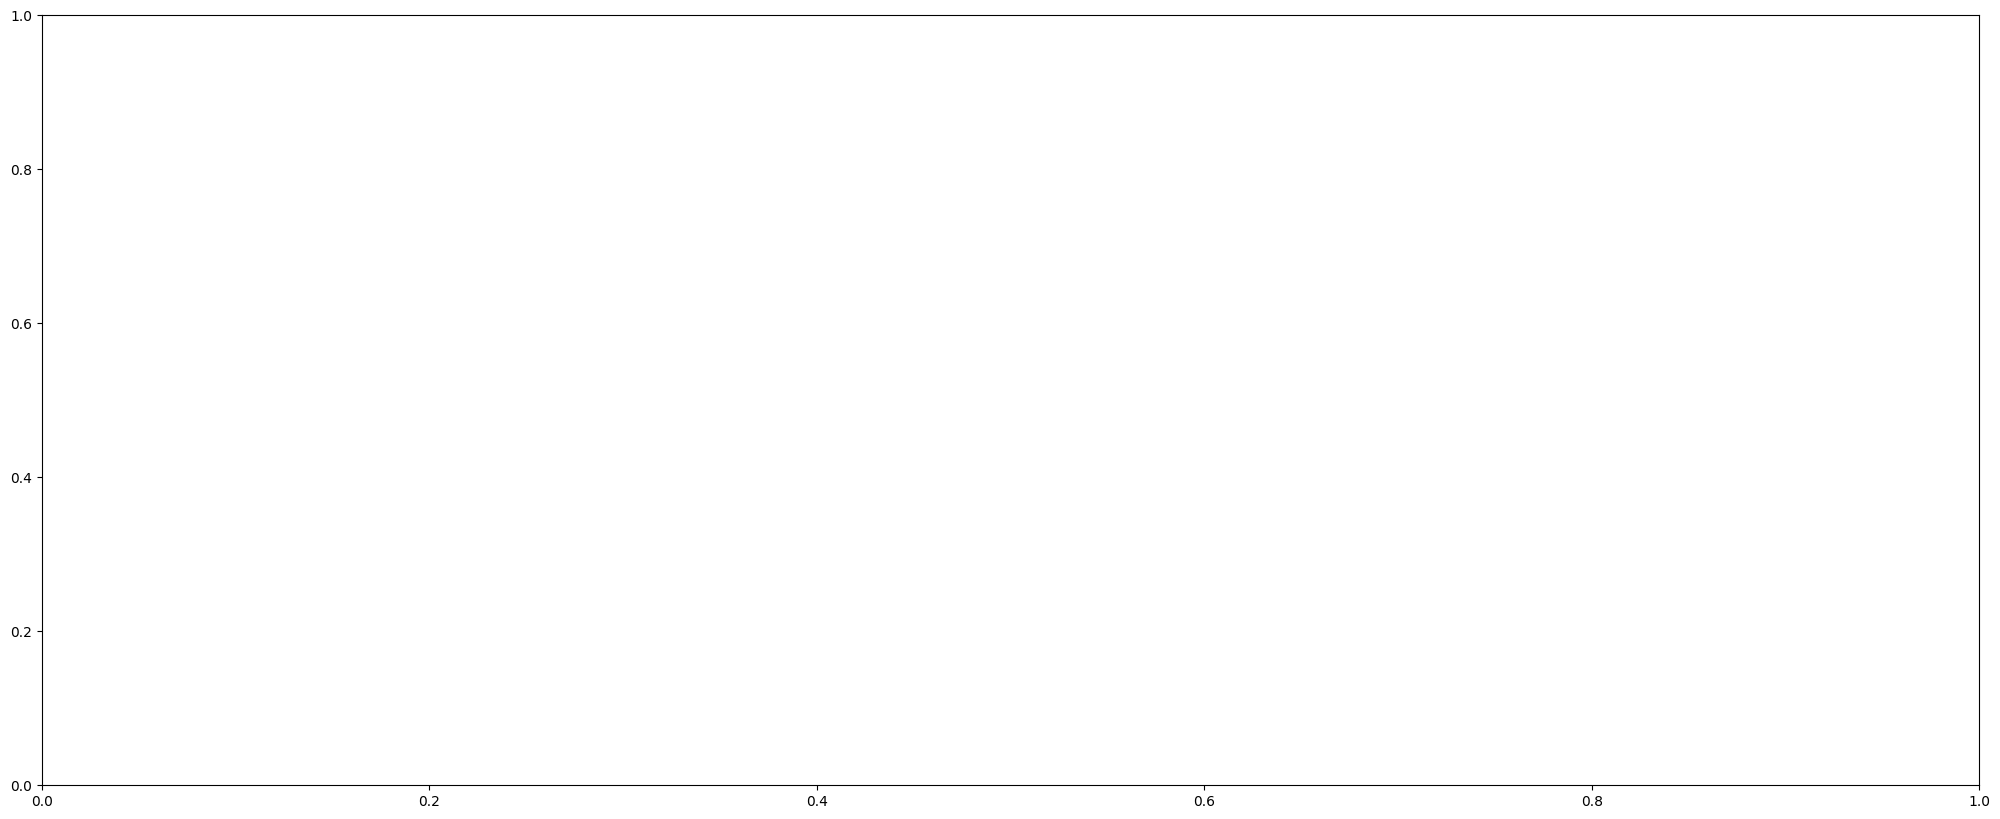

In [155]:
# now plot the input data, the ground thruth and the predictions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 10))
plot_single(
    past_target,
    label["target"],
    forecast,
    context_length=CTX)


## Rolling evaluation

In [156]:
TEST = 100
PDT = PRED

In [157]:
# Split into train/test set
train, test_template = split(
    dataset, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)



### Make predictions

In [158]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=dataset.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=dataset.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

(0.0, 20.0)

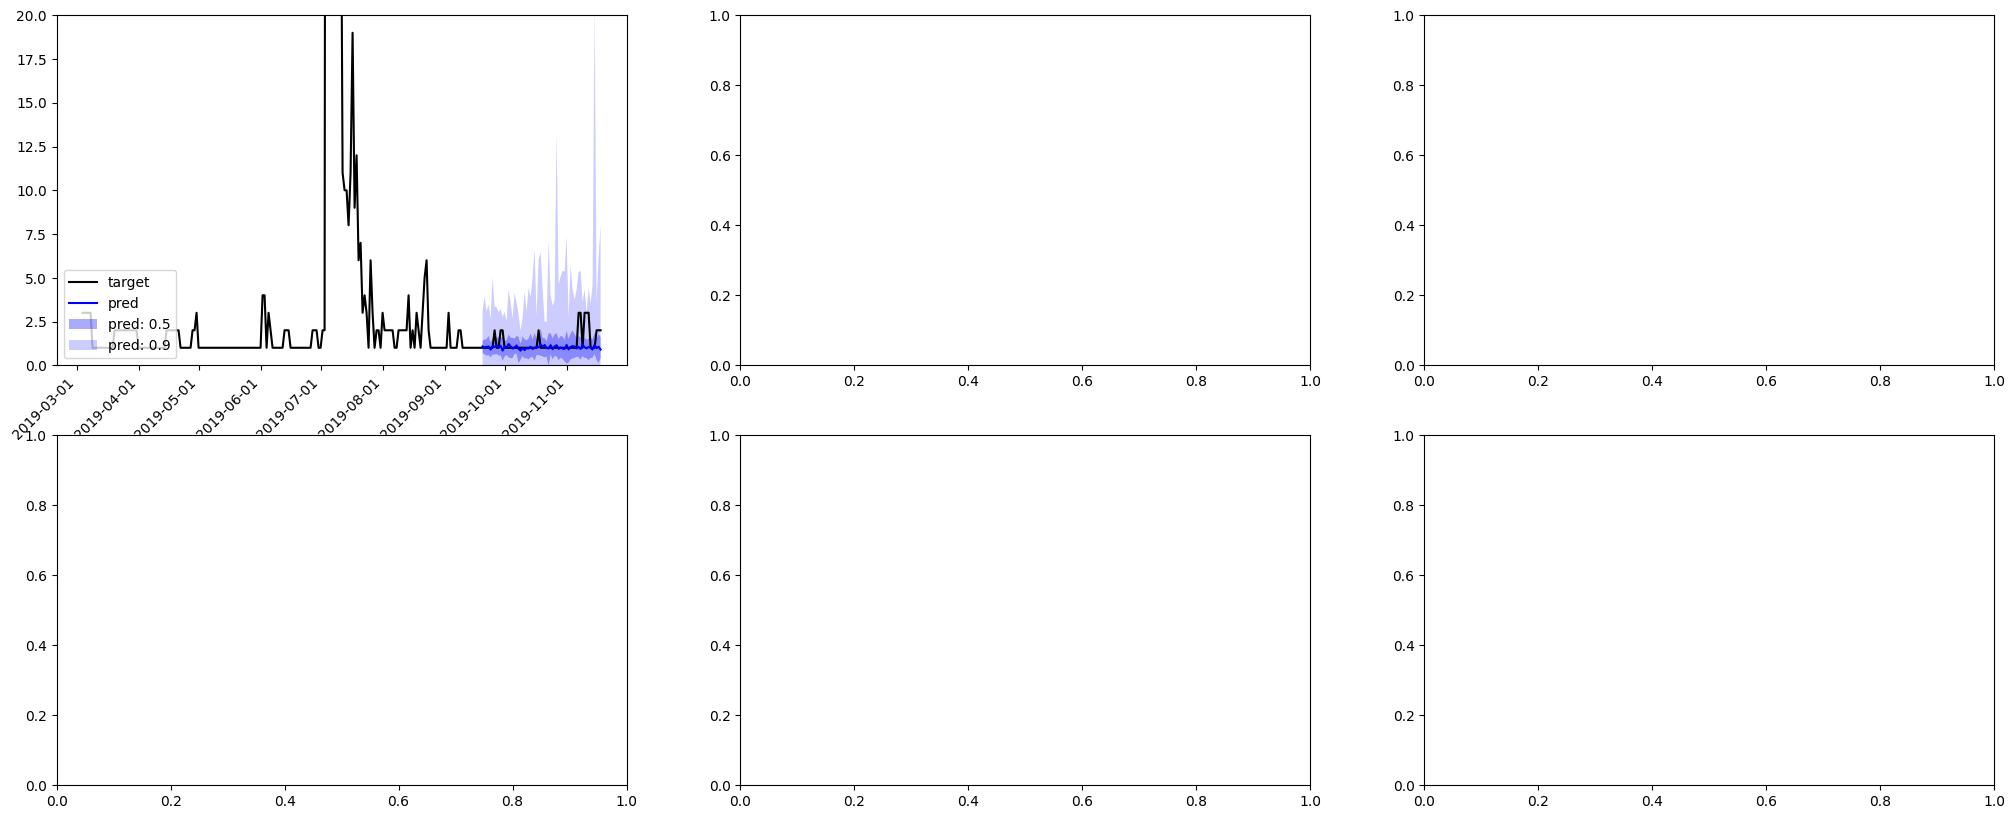

In [159]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)
axes[0,0].set_ylim([0,20])